# Housing prices 

We will build a model of housing prices in California. Our model should learn from the data and be able to predict the median house pricing for any district.

The data we will use comes from the California census.

## Get the Data

### Fetch the data

In [4]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    '''Fetch data from the dowload root, places and extract the data in the housing path'''
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_data()

/var/folders/p6/621t2ymj46z2lwwcp59rbc_w0000gp/T/ipykernel_74480/3751623634.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


###  Load the data

In [2]:
import pandas as pd

def load_data(data_path=HOUSING_PATH):
    return pd.read_csv(os.path.join(data_path, "housing.csv"))

In [6]:
housing = load_data()

## Explore the data

In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can see that the dataframe is almost complete but some info is missing (notice the total_bedrooms)

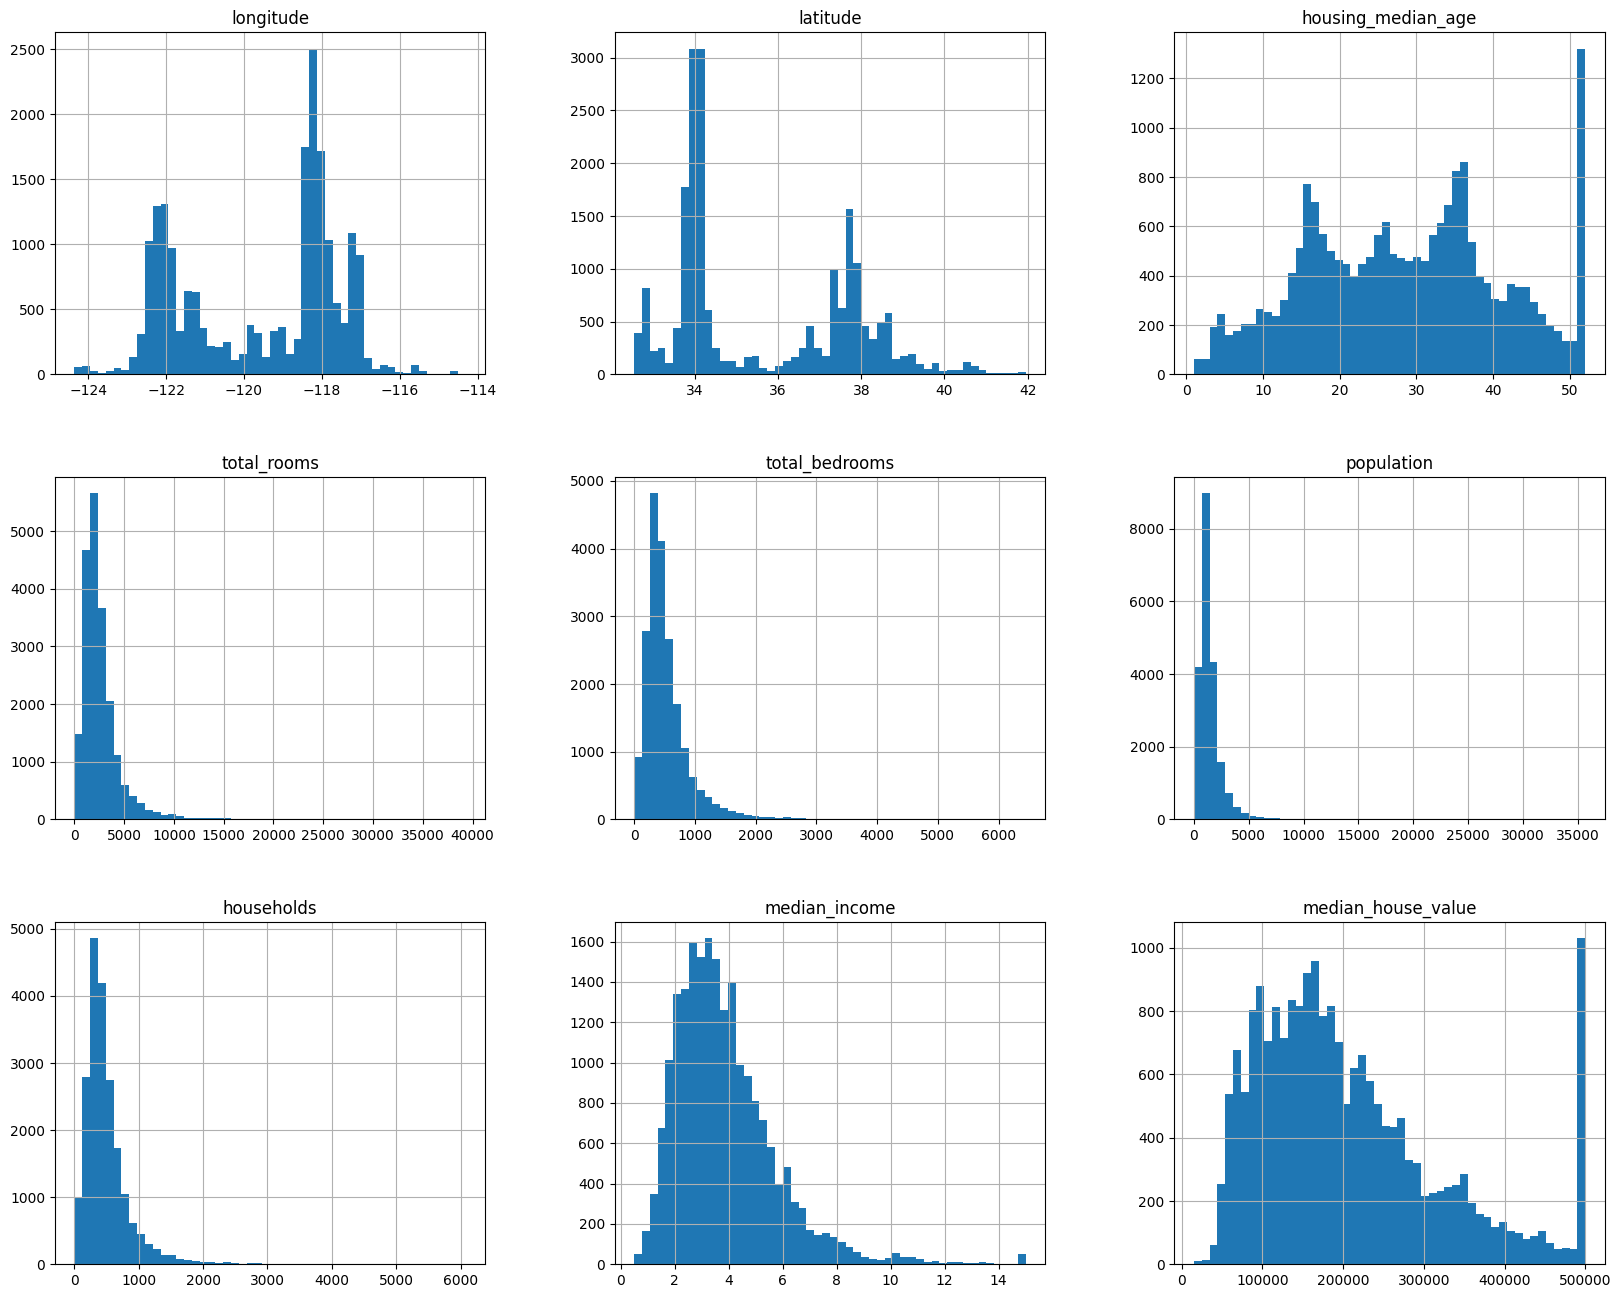

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,16))
plt.show()

It seems some of the values are capped (serious problem) or scaled, we will have to deal with those missing/scaled values.

## Train/Test sets

We will separate the dataset in two: the **Training/Test sets**. 

We have to avoid any instance of the training set to eventually appear in the test set, so we create a unique id for each instance and separate it accordingly to avoid mixing in other runs or if we refetch the data.

In [22]:
housing_with_id = housing.reset_index()
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [23]:
housing_with_id["index"].nunique()

20640

Since we just used the index as identifier, we must make sure that any new data will be appended to the end of the dataset to avoid repeated ids. (We could use stable features to determine the id (longitude and latitude))

In [24]:
import numpy as np
from zlib import crc32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

def test_set_check(id, test_ratio):
    '''Calculates the hash of each instance putting that instance in the test set (returns True) if the hash is lower than max hash value'''
    return crc32(np.int64(id)) & 0xffffffff < test_ratio * 2**32


In [25]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Other option with sklearn:

In [ ]:
# from sklearn.model_selection import train_test_split

# train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Stratification

To assure representativity of the various categories of income we must stratify the data to avoid bias in the models prediction.

<Axes: >

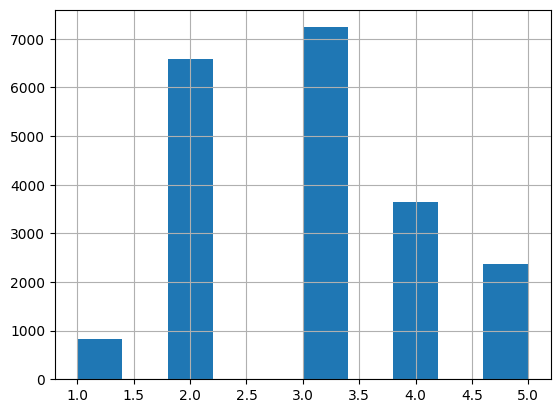

In [27]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1,2,3,4,5])
housing["income_cat"].hist()

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # 1 split: train/test
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [79]:
strat_train_set["income_cat"].value_counts()/len(strat_train_set)

KeyError: 'income_cat'

Comparing to the previous histogram, it seems that the train set is correctly stratified.

In [31]:
# Drop the income category column in the train and test sets

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize Data

By doing the discovery and visualization of the data we can get some insights


In [80]:
housing = strat_train_set.copy()

### Visualize the data

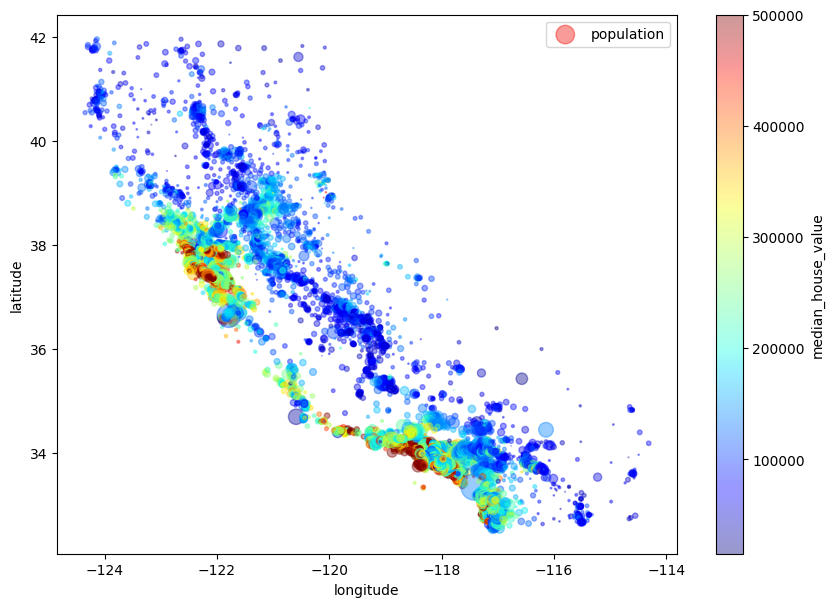

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7), 
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
# s : bubble size
# c : color of the bubble
plt.legend()

We notice that the location is strongly related to the median house price.

### Correlation

Since the dataset isn't that big, we can calculate Pearson's correlation coefficient to determine the correlation of each attibute in respect to the median house value.

First we must convert ocean_proximity to numerical values, here we chose to normalize it in respect to the biggest mean median_house_price related to its proximity.

In [62]:
means = housing.groupby('ocean_proximity')['median_house_value'].mean()
means = means/max(means)

In [63]:
housing['ocean_proximity'] = housing['ocean_proximity'].map(means)
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,0.356937
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,0.707375
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,0.356937
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,0.707375
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,0.685931


Now we can explore new features that might also be important (number of rooms/household seems a interesting information to explore)

In [72]:
housing["median_rooms_per_household"] = housing["total_rooms"] / housing["households"]

In [73]:
corr = housing.corr()
corr["median_house_value"].sort_values(ascending=False)

median_house_value             1.000000
median_income                  0.687151
ocean_proximity                0.485289
median_rooms_per_household     0.146255
total_rooms                    0.135140
housing_median_age             0.114146
households                     0.064590
total_bedrooms                 0.047781
median_people_per_household   -0.021991
population                    -0.026882
longitude                     -0.047466
latitude                      -0.142673
Name: median_house_value, dtype: float64

### Transformers

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

class OceanProximityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col='median_house_value', feature_col='ocean_proximity'):
        self.target_col = target_col
        self.feature_col = feature_col
        self.mapping_ = None

    def fit(self, X, y=None):
        means = X.groupby(self.feature_col)[self.target_col].mean()
        self.mapping_ = means / means.max()
        return self

    def transform(self, X):
        X = X.copy()
        X[self.feature_col] = X[self.feature_col].map(self.mapping_)
        return X

class RoomsPerHouseholdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["median_rooms_per_household"] = X["total_rooms"] / X["households"]
        return X


### Transformation Pipelines

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipeline_features = Pipeline([
    ('ocean_proximity_transformer', OceanProximityTransformer()),
    ('rooms_per_household_transformer', RoomsPerHouseholdTransformer())
])

pipeline_input_scale = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

In [83]:
housing_tr = pipeline.fit_transform(housing)
housing_tr

array([[-0.94135046,  1.34743822,  0.02756357, ..., -1.16601465,
        -1.4548413 ,  0.01739526],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.62745084,
         0.73653595,  0.56925554],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -1.07439665,
        -1.4548413 , -0.01802432],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5756836 ,
         0.60244145, -0.5092404 ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.44162188,
         0.60244145,  0.32814891],
       [-1.28105026,  2.02567448, -0.13148926, ..., -1.2472608 ,
        -1.4548413 ,  0.01407228]], shape=(16512, 11))